In [8]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [21]:
max_dataset_size = 10000000;
waveform_length = 72;
nb_of_elements = 150000;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nb_of_datasets = 3;
snr_from = 20;
snr_to = 100;
max_shift = 0;
use_horizontal_flip = False;
use_vertical_flip = False;
filter_type = 'high';
sampling_rate = 24000;
passband = np.array([100], dtype=int);
order = 1;



In [22]:
root_folder = os.path.dirname(os.getcwd())
path_to_recordings = path.join(root_folder,'data/synthesized');
path_to_ground_truth_data = path.join(root_folder,'data/synthesized');
path_to_train_data = path.join(root_folder,'data/train_data_re_id.npy');
path_to_train_labels = path.join(root_folder,'data/train_labels_re_id.npy');
sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn
transform_list =[cnn.FilterSignalUsingButtersWorth(filter_type, sampling_rate, passband, order), cnn.OptimizedZScoreNormalizaton()];



In [142]:
# counts each class
classes_per_recording = np.zeros((nb_of_datasets), dtype='int')
for i in range(0 , nb_of_datasets):
    single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
    gt_data = np.load(single_recording_ground_truth);
    classes_per_recording[i] = np.unique(gt_data[1,:]).size;
    print(np.unique(gt_data[1,:]))
    print(np.min(gt_data))
print(classes_per_recording)

# class counter to concatenate classes together from different recordings
class_counter = np.zeros((nb_of_datasets, 1), dtype='int');
class_counter[0] = 0;
for i in range(1, nb_of_datasets):
    class_counter[i] = class_counter[i-1] + classes_per_recording[i - 1] - 1; 
print(class_counter)



[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
0.0
[17 20 13]
[[ 0]
 [16]
 [35]]


In [143]:
# couts sample count for each class
nb_of_classes = int(np.sum(classes_per_recording - 1) + 1);


In [144]:
print(classes_per_recording)
print(class_counter)

[17 20 13]
[[ 0]
 [16]
 [35]]


In [150]:
16+19+12

47

In [146]:
max_dataset_size = max_dataset_size + nb_of_classes - max_dataset_size % nb_of_classes;
samples_per_class = max_dataset_size // nb_of_classes;
print(samples_per_class)
print(max_dataset_size / nb_of_classes)
print(max_dataset_size)


2086
2086.0
100128


In [157]:
dataset = np.empty((1 , 1 ,waveform_length))
labels = np.empty((1, 0), dtype = "int")
# adds single unit activity data
for i in range(0, nb_of_datasets):
    added_sample_counter = np.zeros((classes_per_recording[i] - 1));
    data_iter_counter = 0;
    total_nb_of_samples = int((classes_per_recording[i] - 1) * samples_per_class);
    temp_spikes = np.zeros((total_nb_of_samples, 1, waveform_length));
    temp_labels = np.zeros((1, total_nb_of_samples), dtype='int');
    # generates augmentations until there are same sized samples for each class
    while (data_iter_counter < total_nb_of_samples):
        single_recording_path = path.join(path_to_recordings, 'data_' + str(i + 1) + '.npy');
        single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
        dataset_spikes = cnn.GenerateDataset(single_recording_path, single_recording_ground_truth, waveform_length, 600, snr_from, snr_to, max_shift, use_horizontal_flip, use_vertical_flip, transform_list);
        # adds to temp variable to add to real dataset afterwards
        for j, (data, target) in enumerate(dataset_spikes):
            neuron_index = target.item();
            if(neuron_index > 0 and added_sample_counter[neuron_index - 1] < samples_per_class):
                spike_waveform =  abs(data.numpy());
                temp_spikes[data_iter_counter, :] = spike_waveform;
                class_index = class_counter[i] + neuron_index;
                # changes class index
                temp_labels[0, data_iter_counter] = class_index;
                added_sample_counter[neuron_index - 1] = added_sample_counter[neuron_index - 1] + 1;
                data_iter_counter = data_iter_counter + 1;

    print(added_sample_counter)
    dataset = np.concatenate((dataset, temp_spikes), axis=0)            
    labels = np.concatenate((labels, temp_labels), axis=1)            

    
# adds multi unit activity data
data_iter_counter = 0;
total_nb_of_samples = int(samples_per_class);
temp_spikes = np.zeros((total_nb_of_samples, 1, waveform_length));
temp_labels = np.zeros((1, total_nb_of_samples), dtype='int');
while (data_iter_counter < total_nb_of_samples):
    for i in range(0, nb_of_datasets):
        single_recording_path = path.join(path_to_recordings, 'data_' + str(i + 1) + '.npy');
        single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
        dataset_spikes = cnn.GenerateDataset(single_recording_path, single_recording_ground_truth, waveform_length, 600, snr_from, snr_to, max_shift, use_horizontal_flip, use_vertical_flip, transform_list);
        # adds to temp variable to add to real dataset afterwards
        for j, (data, target) in enumerate(dataset_spikes):
            neuron_index = target.item();
            if(neuron_index == 0 and data_iter_counter < total_nb_of_samples):
                spike_waveform =  abs(data.numpy());
                temp_spikes[data_iter_counter, :] = spike_waveform;
                class_index = neuron_index;
                # changes class index
                temp_labels[0, data_iter_counter] = class_index;
                data_iter_counter = data_iter_counter + 1;
dataset = np.concatenate((dataset, temp_spikes), axis=0)            
labels = np.concatenate((labels, temp_labels), axis=1)            


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  84.3070397526338
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176c18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(16, dtype=torch.int32)
dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.665147664734825
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176c18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>

dataset len:  12008
[2086. 2086. 2086. 2086. 2086. 2086. 2086. 2086. 2086. 2086. 2086. 2086.
 2086. 2086. 2086. 2086.]
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  29.060281521973618
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  58.33405552312458
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176ac8>, <custom_resnet.CustomResnet.FilterSignalUsingB

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  43.2376701766836
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.914404679299224
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  99.54934431140093
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  50.393212324136506
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(16, dtype=torch.int32)
dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  68.9813432056501
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fd060176a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7fd072434c88>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7fd072434e10>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

In [155]:
np.min(labels)

0

In [161]:
class_sample_count = np.unique(labels, return_counts=True)[1]
class_sample_count

array([2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086,
       2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086,
       2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086,
       2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086, 2086,
       2086, 2086, 2086, 2086])

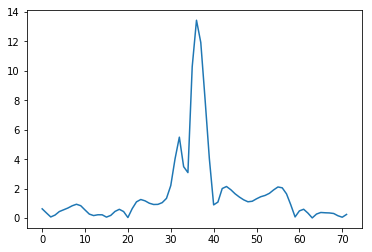

In [ ]:
np.save(path_to_train_data, dataset)
np.save(path_to_train_labels, labels)


In [ ]:
mean = (np.mean(np_data_spikes))
std = (np.std(np_data_spikes))
np.save(path_to_mean_std, [mean, std])

print(mean)
print(std)